In [1]:
question_json = 'data/v2_OpenEnded_mscoco_val2014_questions.json' 
feature_h5 = 'process/genome-trainval_36.h5' # path to trainval_feature.h5
question_pt = 'process/new_2/val_questions.pt'
ckpt = 'trainval_timeban_sum/model.pt'
# ckpt = 'trainval_3100/model.pt'
# ckpt = 'ban/model.pt'
# ckpt = 'updn/model.pt'
# ckpt = 'ban/model.pt'
image_dir = 'data/images/mscoco/images/val2014' # path to mscoco/val2014, containing all mscoco val images
ann_file = 'data/images/mscoco/annotations/instances_val2014.json' # path to mscoco/annotations/instances_val2014.json
vocab_json = 'process/new_2/vocab.json'

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os,sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(sys.argv[1])))) # to import shared utils
import torch
import numpy as np
import pickle
import json
import h5py
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import _pickle as cPickle
import re
from torch.utils.data import Dataset, DataLoader, dataloader

In [3]:
coco = COCO(ann_file)

def todevice(tensor, device):
    if isinstance(tensor, list) or isinstance(tensor, tuple):
        assert isinstance(tensor[0], torch.Tensor)
        return [todevice(t, device) for t in tensor]
    elif isinstance(tensor, torch.Tensor):
        return tensor.to(device)

def invert_dict(d):
    return {v: k for k, v in d.items()}

def expand_batch(*args):
    return (t.unsqueeze(0) for t in args)

def load_vocab(path):
    with open(path, 'r') as f:
        vocab = json.load(f)
        vocab['question_idx_to_token'] = invert_dict(vocab['question_token_to_idx'])
        vocab['answer_idx_to_token'] = invert_dict(vocab['answer_token_to_idx'])
        # vocab['program_idx_to_token'] = invert_dict(vocab['program_token_to_idx'])
    return vocab

def _create_coco_id_to_index():
    """ Create a mapping from a COCO image id into the corresponding index into the h5 file """
    with h5py.File(feature_h5, 'r') as features_file:
        coco_ids = features_file['ids'][()]
    coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}
    return coco_id_to_index

def expand_batch(*args):
    return (t.unsqueeze(0) for t in args)

class VQADataset(Dataset):

    def __init__(self, **kwargs):
        
        vocab_json_path = str(kwargs.pop('vocab_json'))
        print('loading vocab from %s' % (vocab_json_path))
        vocab = load_vocab(vocab_json_path)

        question_pt_path = str(kwargs.pop('question_pt'))
        print('loading questions from %s' % (question_pt_path))
        
        with open(question_pt_path, 'rb') as f:
            obj = pickle.load(f)
            questions = obj['questions']
            questions_len = obj['questions_len']
            q_image_indices = obj['image_idxs']
            answers = obj['answers']
            glove_matrix = obj['glove']
            questions_mask = obj['questions_mask']
            entity_starts = obj['e_starts']
            entity_ends = obj['e_ends']
            entity_masks = obj['e_masks']
            questions_id = obj['questions_id']
        
        use_spatial = kwargs.pop('spatial')
        with h5py.File(kwargs['feature_h5'], 'r') as features_file:
            coco_ids = features_file['ids'][()]
        feat_coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}
        
        self.vocab = vocab
        
        # convert data to tensor
        self.all_answers = answers
        self.all_questions = torch.LongTensor(np.asarray(questions))
        self.all_questions_len = torch.LongTensor(np.asarray(questions_len))
        self.all_q_image_idxs = torch.LongTensor(np.asarray(q_image_indices))
        self.all_questions_mask = torch.FloatTensor(np.asarray(questions_mask))
        self.all_entity_starts = torch.LongTensor(np.asarray(entity_starts))
        self.all_entity_ends = torch.LongTensor(np.asarray(entity_ends))
        self.all_entity_masks = torch.LongTensor(np.asarray(entity_masks))
        self.all_questions_id = torch.LongTensor(np.asarray(questions_id))

        self.feature_h5 = feature_h5
        self.feat_coco_id_to_index = feat_coco_id_to_index
        self.num_answer = len(vocab['answer_token_to_idx'])
        self.use_spatial = use_spatial
        self.num_token = len(vocab['question_token_to_idx'])


    def __getitem__(self, index):
        answer = self.all_answers[index] if self.all_answers is not None else None
        if answer is not None:
            _answer = torch.zeros(self.num_answer)
            for i in answer:
                _answer[i] += 1
            answer = _answer
        question = self.all_questions[index]
        questions_id = self.all_questions_id[index]
        question_len = self.all_questions_len[index]
        question_mask = self.all_questions_mask[index]

        entity_start = self.all_entity_starts[index]
        entity_end = self.all_entity_ends[index]
        entity_mask = self.all_entity_masks[index]

        image_idx = self.all_q_image_idxs[index].item() # coco_id
        # fetch vision features
        index = self.feat_coco_id_to_index[image_idx]
        with h5py.File(self.feature_h5, 'r') as f:
            vision_feat = f['features'][index]
            boxes = f['boxes'][index]
            w = f['widths'][index]
            h = f['heights'][index]
        
        spatial_feat = np.zeros((4, len(boxes[0])))
        spatial_feat[0, :] = boxes[0, :] * 2 / w - 1 # x1
        spatial_feat[1, :] = boxes[1, :] * 2 / h - 1 # y1
        spatial_feat[2, :] = boxes[2, :] * 2 / w - 1 # x2
        spatial_feat[3, :] = boxes[3, :] * 2 / h - 1 # y2
        # spatial_feat[4, :] = (spatial_feat[2, :]-spatial_feat[0, :]) * (spatial_feat[3, :]-spatial_feat[1, :])

        if self.use_spatial:
            vision_feat = np.concatenate((vision_feat, spatial_feat), axis=0)
        vision_feat = torch.from_numpy(vision_feat).float().transpose(-1,-2)
        #########
        num_feat = boxes.shape[1]
        relation_mask = np.zeros((num_feat,num_feat))
        for i in range(num_feat):
            for j in range(i, num_feat):
                # if there is no overlap between two bounding box
                if boxes[0,i]>boxes[2,j] or boxes[0,j]>boxes[2,i] or boxes[1,i]>boxes[3,j] or boxes[1,j]>boxes[3,i]:
                    pass
                else:
                    relation_mask[i,j] = relation_mask[j,i] = 1
        relation_mask = torch.from_numpy(relation_mask).byte()

        q_onehot = torch.zeros(question_len, self.num_token).scatter_(1, question[:question_len].unsqueeze(-1), 1)
        entity_label = []
        for i in range(4):
            ee = q_onehot[entity_start[i] : entity_end[i]].sum(0)
            entity_label.append(ee)
        
        entity_label = torch.stack(entity_label)

        return (boxes, questions_id, answer, question, vision_feat, entity_start, entity_end, entity_mask, entity_label, question_mask, relation_mask, question_len)

    def __len__(self):
        return len(self.all_questions)

loading annotations into memory...
Done (t=3.97s)
creating index...
index created!


In [4]:
with open(question_json, 'r') as f:
    questions_json = json.load(f)

with open(vocab_json) as f:
    vocab = json.load(f)
    
token_to_index = vocab['question_token_to_idx']
answer_to_index = vocab['answer_token_to_idx']
    
coco_id_to_index = _create_coco_id_to_index()

In [5]:
device = 'cuda'
loaded = torch.load(ckpt, map_location={'cuda:0': 'cpu'})
model_kwargs = loaded['model_kwargs']
    
dataset_kwargs = {
            'question_pt': question_pt,
            'vocab_json': vocab_json,
            'feature_h5': feature_h5,
            'spatial': model_kwargs['spatial'],
        }

validate_dataset = VQADataset(**dataset_kwargs)

loading vocab from process/new_2/vocab.json
loading questions from process/new_2/val_questions.pt


In [16]:
####choose a test item
index = 2331
batch = validate_dataset.__getitem__(index)

boxes, q_ids, answer, *batch_input = [todevice(x, device) for x in batch]
batch_input = [x.unsqueeze(0).detach() for x in batch_input]
boxes = batch[0].T

In [17]:
##Change the models
from timeban_2_forward import Net
model_kwargs.update({'vocab': validate_dataset.vocab, 'device': device})
model = Net(**model_kwargs).to(device)

model.load_state_dict(loaded['state_dict'])

<All keys matched successfully>

In [18]:
model.eval()
output, z_seq = model(*batch_input)

In [19]:
def drawrect(drawcontext, xy, outline=None, width=0):
    x1, y1, x2, y2 = xy
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)
    
def plot_rect(image, boxes):
    img = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(img)
    for k in range(15):
        box = boxes[k,:]
        drawrect(draw, box, outline='green', width=3)
    img = np.asarray(img)
    return img

def plot_attention(img, boxes, att):
    white = np.asarray([255, 255, 255])
    pixel_peak = np.zeros((img.shape[0], img.shape[1]))
    for k in range(36):
        for i in range(int(boxes[k][1]), int(boxes[k][3])):
            for j in range(int(boxes[k][0]), int(boxes[k][2])):
                pixel_peak[i,j] = max(pixel_peak[i,j], att[k])
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            img[i,j] = white * (1-pixel_peak[i,j]) + img[i,j] * pixel_peak[i,j]
    if torch.max(att) > 0.5:
        red_box = boxes[torch.argmax(att),:]
        img = Image.fromarray(np.uint8(img))
        draw = ImageDraw.Draw(img)
#         drawrect(draw, red_box, outline='red', width=4)
    img = np.asarray(img)
    return img

What are the kids eating?


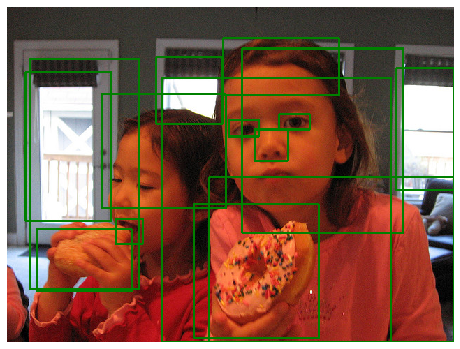

In [20]:
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

question = questions_json['questions'][index]
q_str = question['question']
coco_id = question['image_id']
print(q_str)

img_obj = coco.loadImgs([coco_id])[0]
img = io.imread(os.path.join(image_dir, img_obj['file_name']))

plot_img = plot_rect(copy.copy(img), boxes)
plt.axis('off')
plt.imshow(plot_img)

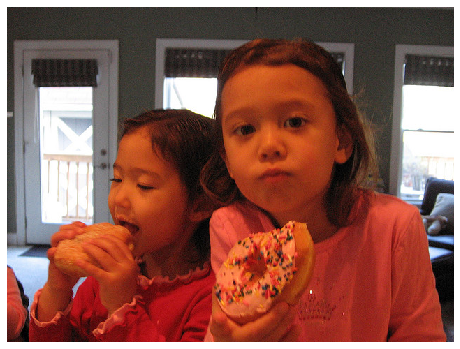

In [21]:
plt.axis('off')
plt.imshow(img)

In [22]:
ans_idx = torch.argmax(output.squeeze(0))
print(list(answer_to_index)[ans_idx])

donuts


In [23]:
print('label:')
ans_idx = torch.argmax(batch[2].squeeze(0))
print(list(answer_to_index)[ans_idx])

label:
donuts


In [24]:
# import matplotlib.cm as cm
# import torch.nn.functional as F
# n_classes = 36
# t = 4.0
# M = 128 # number of samples used to approximate distribution mean

# # ncols = len(z_seq)//2+1
# # fig, axes = plt.subplots(nrows=4, ncols=ncols, figsize=(14, 6),
# #                          subplot_kw={'xticks': range(n_classes),
# #                                      'yticks': [0., 0.5, 1.]})
# # axes[0, 0].set_ylabel('Expectation')
# # axes[1, 0].set_ylabel('Gumbel Softmax Sample')
# # axes[2, 0].set_ylabel('Expectation')
# # axes[3, 0].set_ylabel('Gumbel Softmax Sample')
# pylab.rcParams['figure.figsize'] = (5.0, 5.0)

# for n, z in enumerate(z_seq):
# #     logits = todevice(z.logits, 'cpu')
# #     dist = GumbelCategorical(logits)
#     dist = z
#     mean = torch.zeros_like(z.logits)
#     for _ in range(M):
#         mean += dist.sample().exp()/ M
#     sample = dist.sample().exp()
#     plt.bar(np.arange(n_classes), sample.detach().cpu().numpy().reshape(n_classes),color=cm.plasma(0.75 * n / n_classes))
#     plt.pause(0.0001)
    
# # #     axes[2 * n//(ncols), n%ncols].set_title('T = {}'.format(t))
# #     axes[2 * (n//(ncols)), n%ncols].set_ylim((0, 1.1))
# #     axes[2 * (n//(ncols))+1, n%ncols].set_ylim((0, 1.1))
# #     axes[2 * (n//(ncols)), n%ncols].bar(np.arange(n_classes), mean.detach().cpu().numpy().reshape(n_classes),
# #                    color=cm.plasma(0.75 * n /  n_classes))
# #     axes[2 * (n//(ncols))+1, n%ncols].bar(np.arange(n_classes), sample.detach().cpu().numpy().reshape(n_classes),
# #                    color=cm.plasma(0.75 * n / n_classes))

tensor(0.5274, device='cuda:0', grad_fn=<MaxBackward1>)


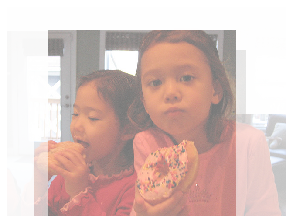

tensor(0.4140, device='cuda:0', grad_fn=<MaxBackward1>)


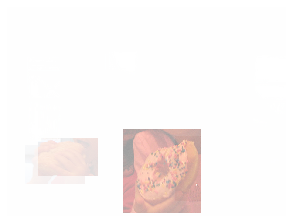

tensor(0.9511, device='cuda:0', grad_fn=<MaxBackward1>)


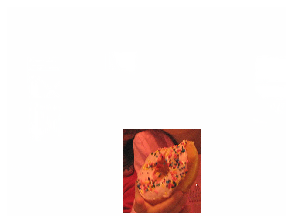

IndexError: list index out of range

In [25]:
import torch.nn.functional as F
pylab.rcParams['figure.figsize'] = (5.0, 10.0)
for t in range(6):
    a = z_seq[t].sample().exp().squeeze(0)
#     a = F.softmax(z_seq[t].logits.squeeze(0), dim=-1)
#     a = F.softmax(z_seq[t], dim=-1)
    print(a.max())
#     a = a / (a.max())
    plot_img = plot_attention(copy.copy(img), boxes, a)
    plt.axis('off')
    plt.imshow(plot_img)
    plt.pause(0.0001)

In [ ]:
plot_img = plot_attention(copy.copy(img), boxes, att.squeeze(0))
plt.axis('off')
plt.imshow(plot_img)